##Problem Statement

Your client is a large MNC and they have 9 broad verticals across the organisation. One of the problem your client is facing is around identifying the right people for promotion (only for manager position and below) and prepare them in time.

They have provided multiple attributes around Employee's 
past and current performance along with demographics. Now, The task is to predict whether a potential promotee at checkpoint in the test set will be promoted or not after the evaluation process.

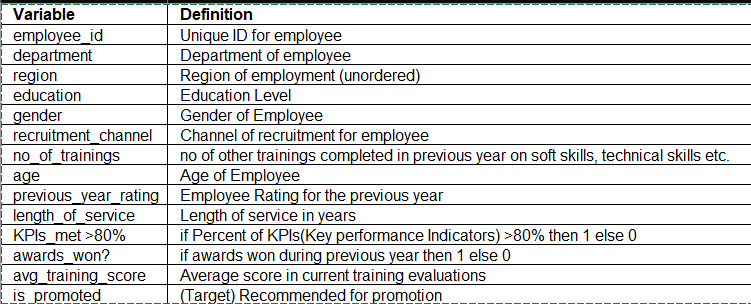


In [50]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc,f1_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier


# Reading Input files

In [51]:
train=pd.read_csv("train_LZdllcl.csv")
test=pd.read_csv("test_2umaH9m.csv")
submission=pd.read_csv("sample_submission_M0L0uXE.csv")

# EDA

In [52]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [53]:
test.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [54]:
submission.head()

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0


In [55]:
train.shape,test.shape,submission.shape

((54808, 14), (23490, 13), (23490, 2))

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [57]:
ig_cols=['employee_id','is_promoted']

Dependency of KPIs with Promotion


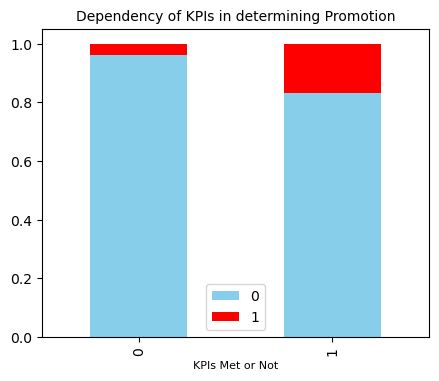

In [58]:

data = pd.crosstab(train['KPIs_met >80%'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (5, 4), color = ['skyblue', 'red'])

plt.title('Dependency of KPIs in determining Promotion', fontsize = 10)
plt.xlabel('KPIs Met or Not', fontsize = 8)
plt.legend()
plt.show()

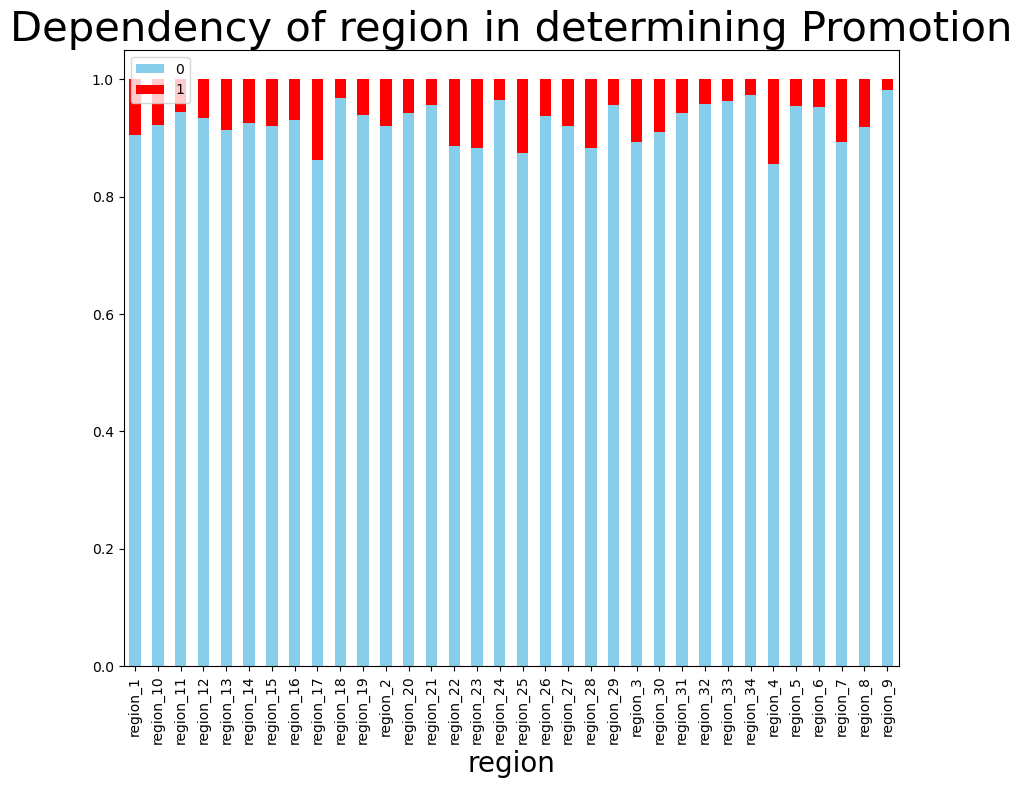

In [59]:


data = pd.crosstab(train['region'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (10, 8), color = ['skyblue', 'red'])

plt.title('Dependency of region in determining Promotion', fontsize = 30)
plt.xlabel('region', fontsize = 20)
plt.legend()
plt.show()

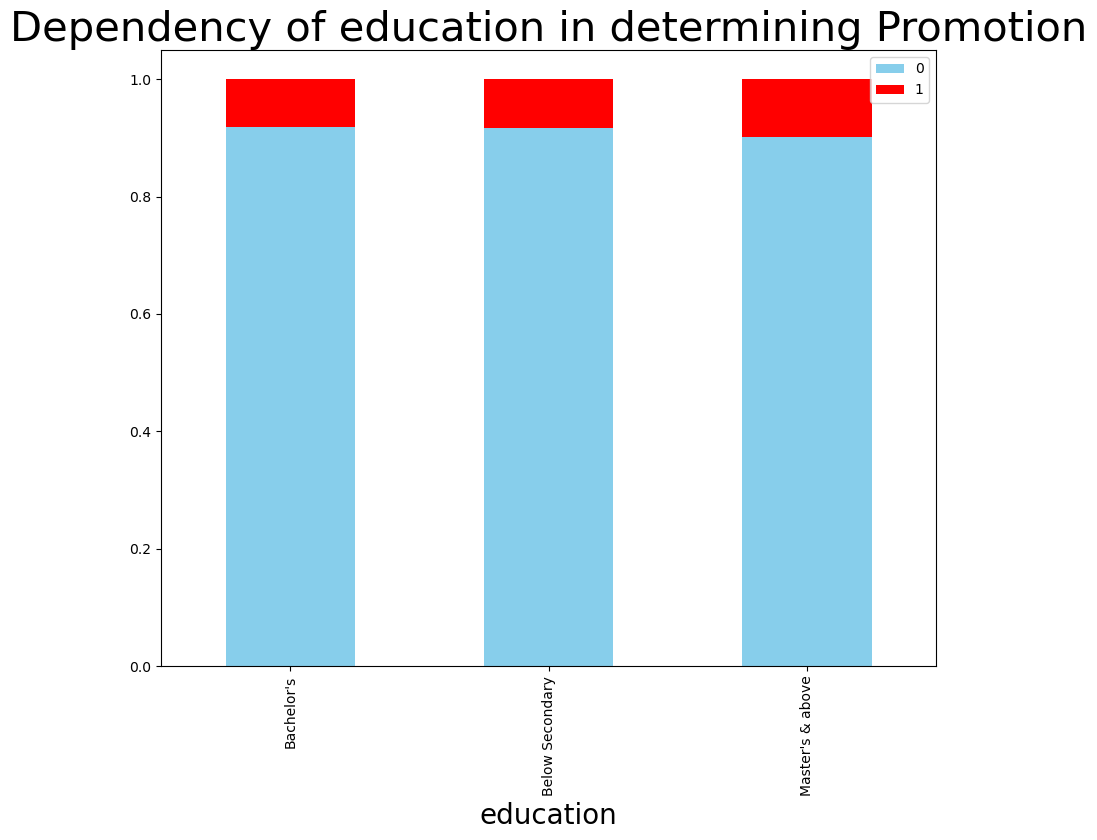

In [60]:
data = pd.crosstab(train['education'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (10, 8), color = ['skyblue', 'red'])

plt.title('Dependency of education in determining Promotion', fontsize = 30)
plt.xlabel('education', fontsize = 20)
plt.legend()
plt.show()

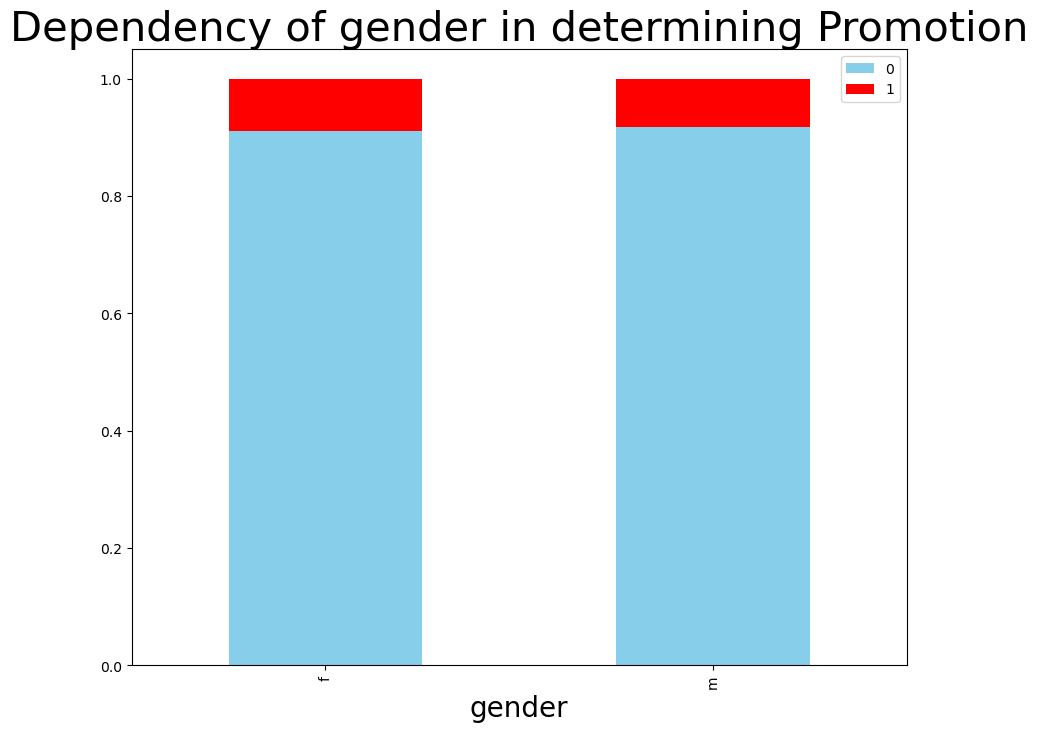

In [61]:
data = pd.crosstab(train['gender'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (10, 8), color = ['skyblue', 'red'])

plt.title('Dependency of gender in determining Promotion', fontsize = 30)
plt.xlabel('gender', fontsize = 20)
plt.legend()
plt.show()

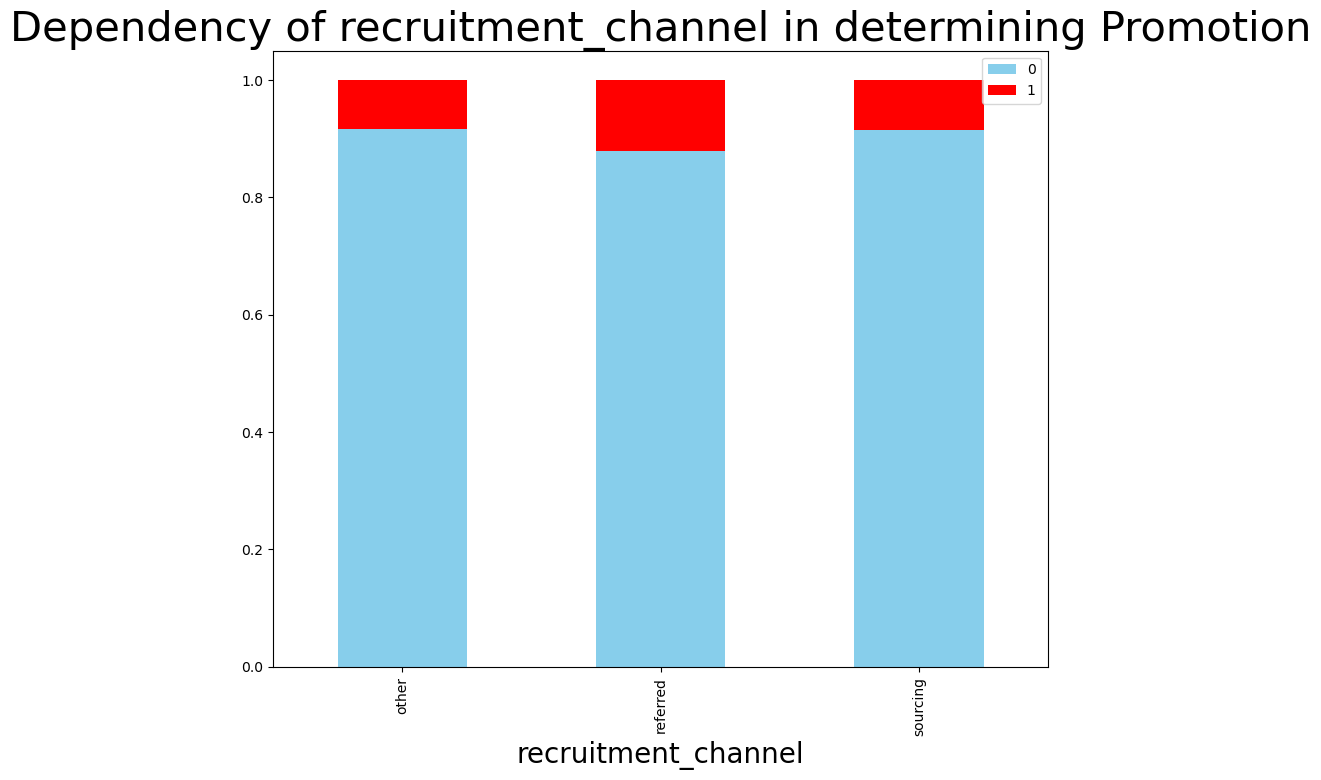

In [62]:
data = pd.crosstab(train['recruitment_channel'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (10, 8), color = ['skyblue', 'red'])

plt.title('Dependency of recruitment_channel in determining Promotion', fontsize = 30)
plt.xlabel('recruitment_channel', fontsize = 20)
plt.legend()
plt.show()

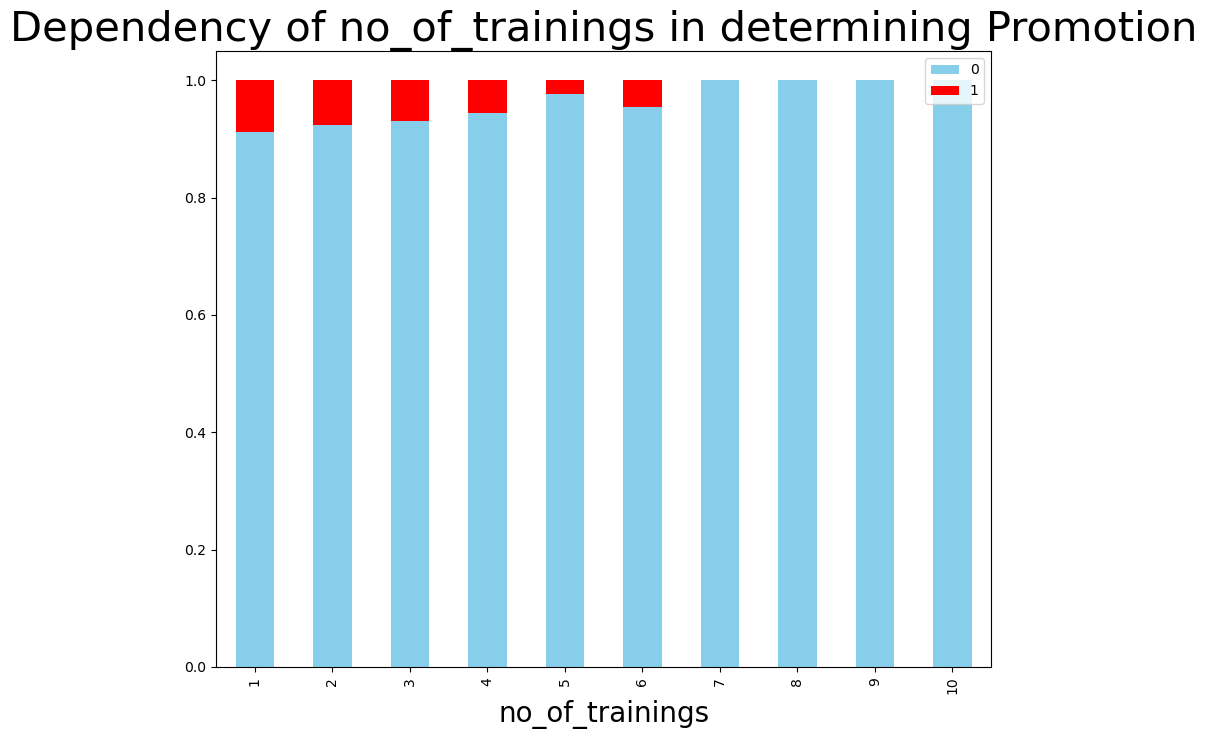

In [63]:
data = pd.crosstab(train['no_of_trainings'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (10, 8), color = ['skyblue', 'red'])

plt.title('Dependency of no_of_trainings in determining Promotion', fontsize = 30)
plt.xlabel('no_of_trainings', fontsize = 20)
plt.legend()
plt.show()

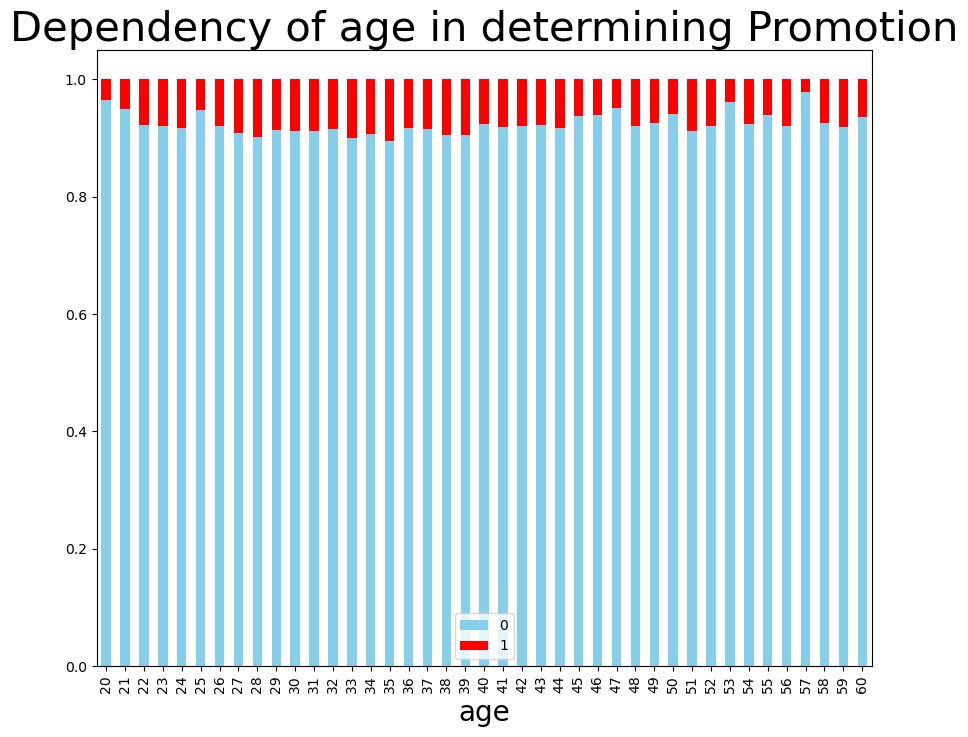

In [64]:
data = pd.crosstab(train['age'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (10, 8), color = ['skyblue', 'red'])

plt.title('Dependency of age in determining Promotion', fontsize = 30)
plt.xlabel('age', fontsize = 20)
plt.legend()
plt.show()

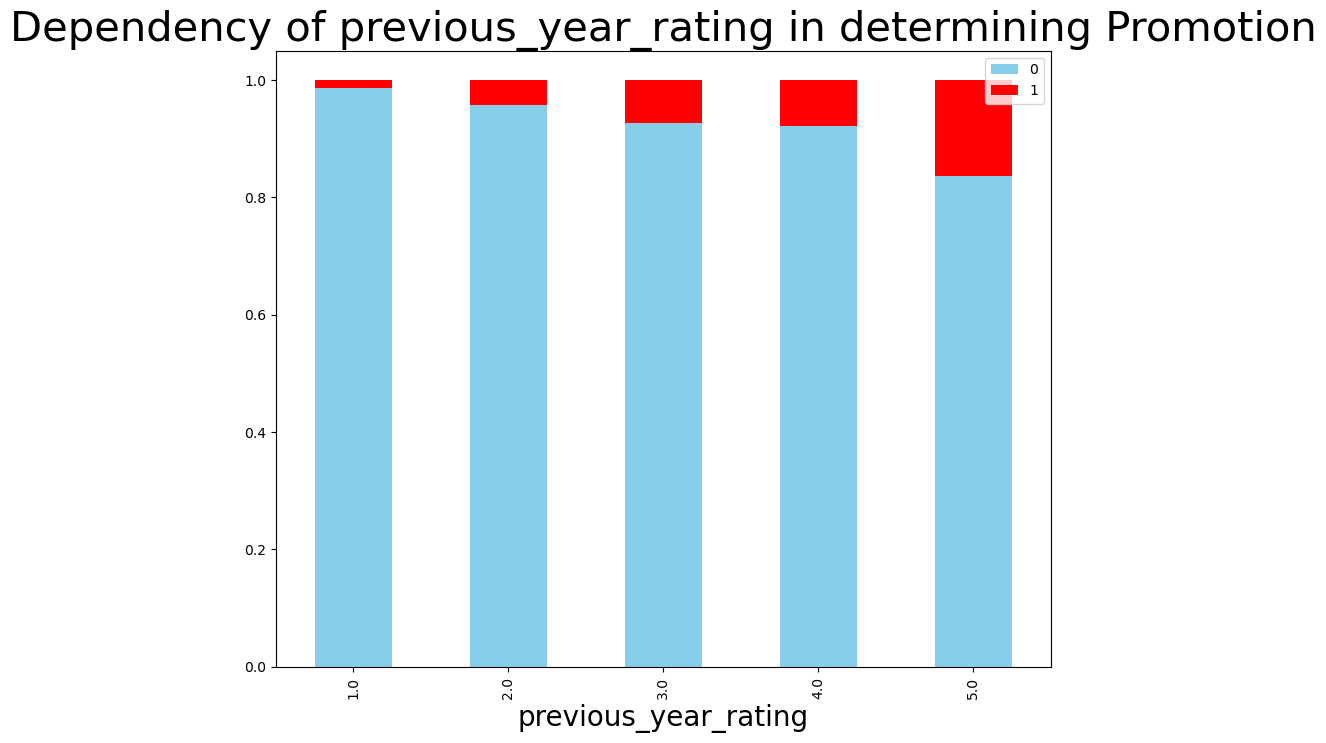

In [65]:
data = pd.crosstab(train['previous_year_rating'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (10, 8), color = ['skyblue', 'red'])

plt.title('Dependency of previous_year_rating in determining Promotion', fontsize = 30)
plt.xlabel('previous_year_rating', fontsize = 20)
plt.legend()
plt.show()

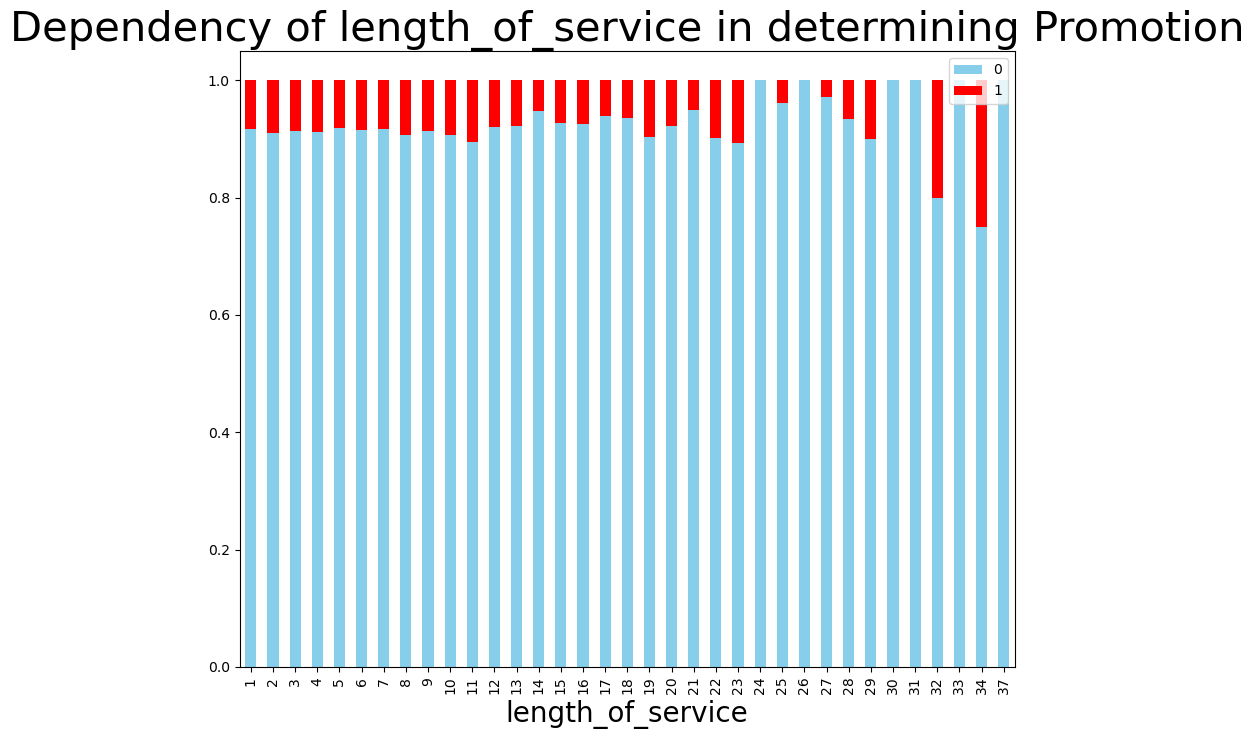

In [66]:
data = pd.crosstab(train['length_of_service'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (10, 8), color = ['skyblue', 'red'])

plt.title('Dependency of length_of_service in determining Promotion', fontsize = 30)
plt.xlabel('length_of_service', fontsize = 20)
plt.legend()
plt.show()

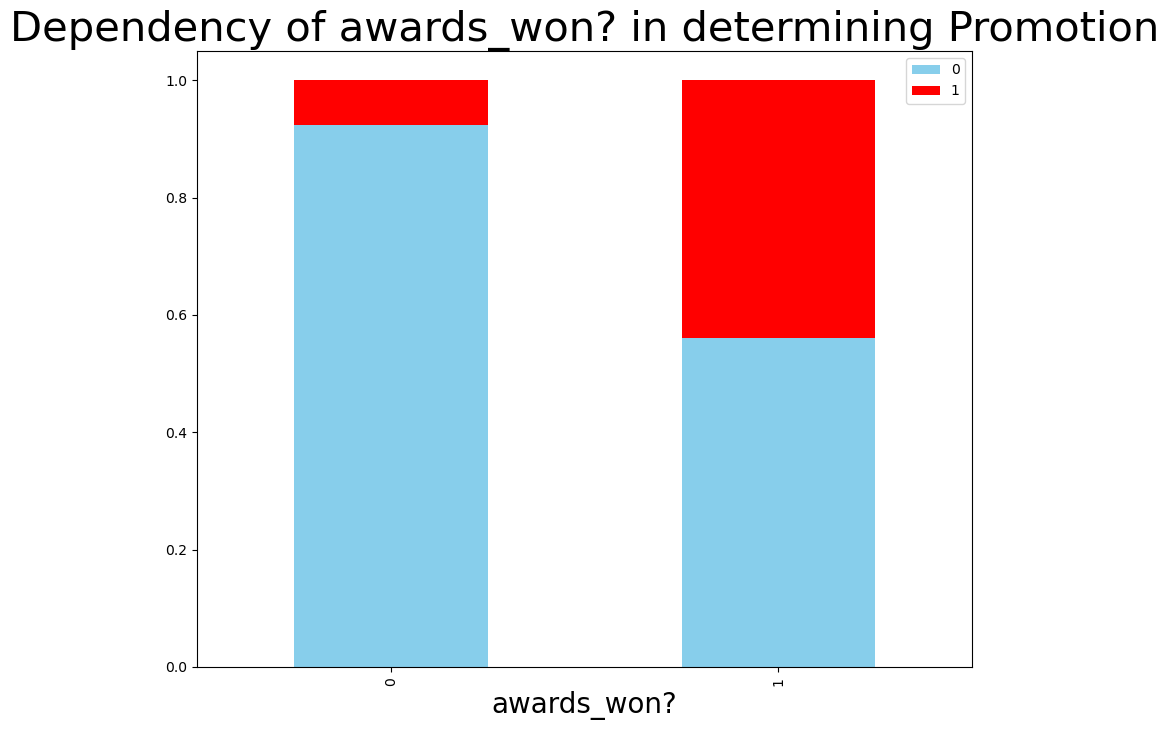

In [67]:
data = pd.crosstab(train['awards_won?'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (10, 8), color = ['skyblue', 'red'])

plt.title('Dependency of awards_won? in determining Promotion', fontsize = 30)
plt.xlabel('awards_won?', fontsize = 20)
plt.legend()
plt.show()

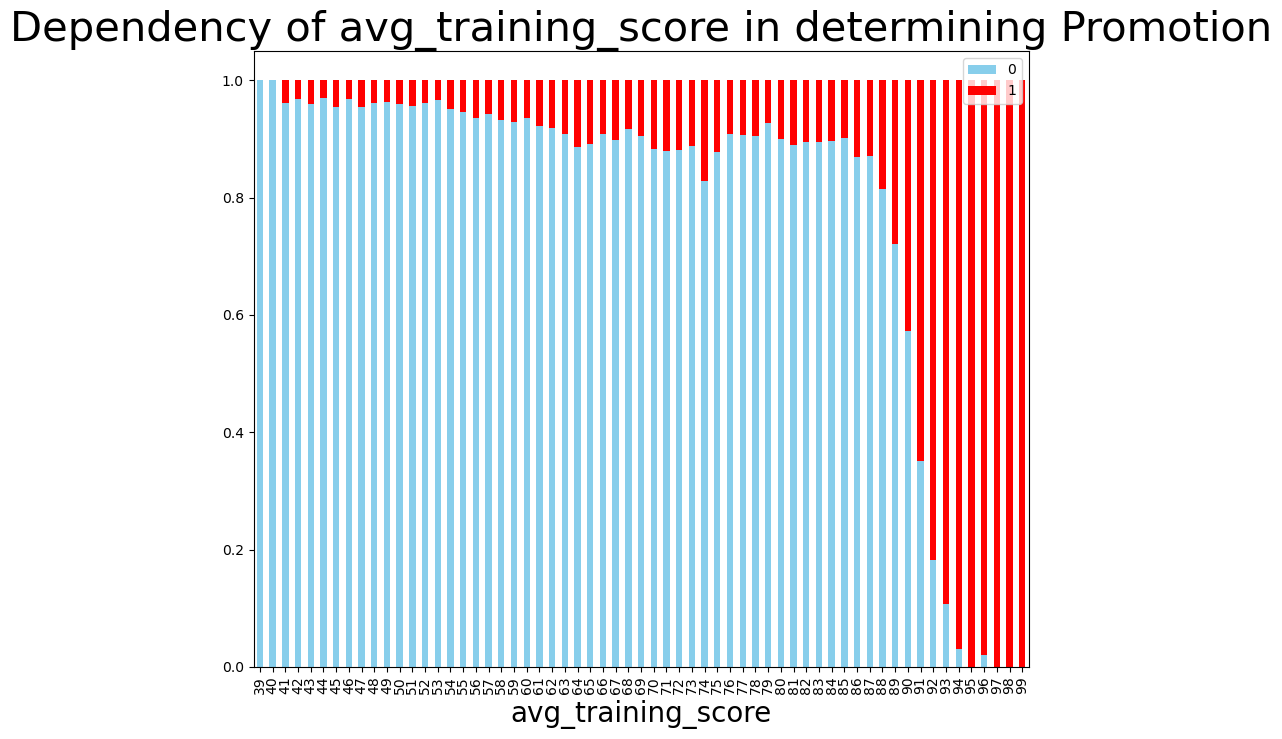

In [68]:
data = pd.crosstab(train['avg_training_score'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (10, 8), color = ['skyblue', 'red'])

plt.title('Dependency of avg_training_score in determining Promotion', fontsize = 30)
plt.xlabel('avg_training_score', fontsize = 20)
plt.legend()
plt.show()

In [69]:
train.is_promoted.value_counts()

is_promoted
0    50140
1     4668
Name: count, dtype: int64

# Dataset is Imbalanced. We have less records for 1. We may need to try sampling technique

[Text(0, 0, '50140'), Text(0, 0, '4668')]

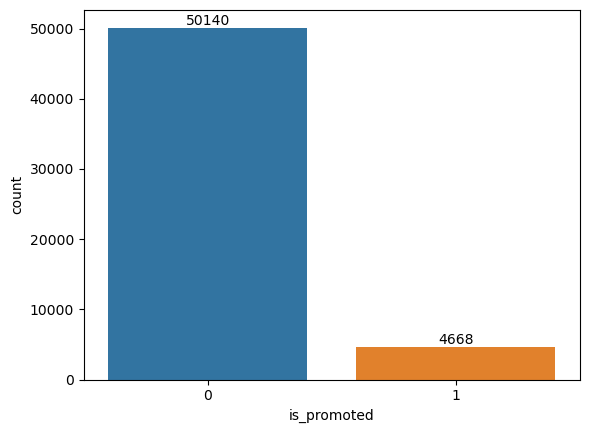

In [70]:
ax = sns.countplot(x='is_promoted', data=train)
ax.bar_label(ax.containers[0])

<Axes: xlabel='avg_training_score', ylabel='length_of_service'>

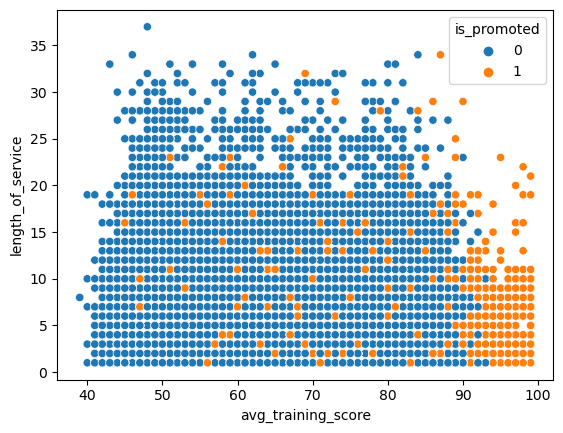

In [71]:
sns.scatterplot(x = 'avg_training_score', y = 'length_of_service', hue = 'is_promoted', data = train )

In [72]:
train.select_dtypes(include=np.number).corr()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
employee_id,1.000000,-0.005121,0.000437,0.004533,0.001274,-0.002501,0.008420,-0.000586,0.001206
no_of_trainings,-0.005121,1.000000,-0.081278,-0.063126,-0.057275,-0.045576,-0.007628,0.042517,-0.024896
age,0.000437,-0.081278,1.000000,0.006008,0.657111,-0.025592,-0.008169,-0.048380,-0.017166
previous_year_rating,0.004533,-0.063126,0.006008,1.000000,0.000253,0.351578,0.027738,0.075139,0.159320
length_of_service,0.001274,-0.057275,0.657111,0.000253,1.000000,-0.077693,-0.039927,-0.038122,-0.010670
KPIs_met >80%,-0.002501,-0.045576,-0.025592,0.351578,-0.077693,1.000000,0.097000,0.078391,0.221582
awards_won?,0.008420,-0.007628,-0.008169,0.027738,-0.039927,0.097000,1.000000,0.072138,0.195871
avg_training_score,-0.000586,0.042517,-0.048380,0.075139,-0.038122,0.078391,0.072138,1.000000,0.181147
is_promoted,0.001206,-0.024896,-0.017166,0.159320,-0.010670,0.221582,0.195871,0.181147,1.000000


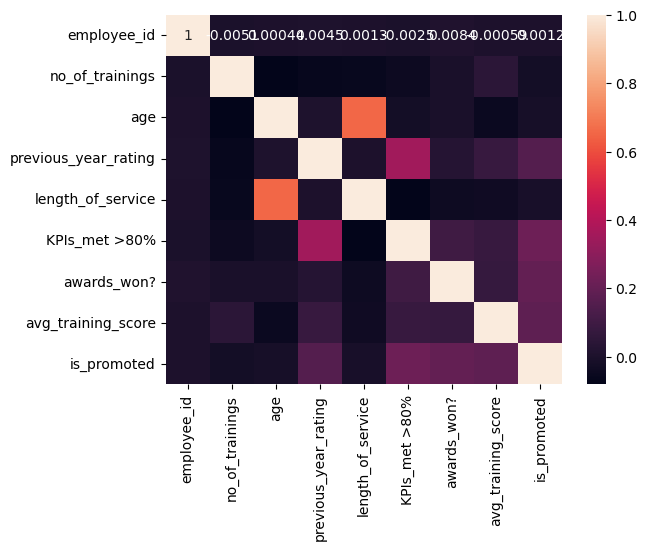

In [73]:
ax=sns.heatmap(train.select_dtypes(include=np.number).corr(), annot = True)

# EDA Observations:

# PreProcessing

In [74]:
train.isna().sum()/train.shape[0]*100

employee_id             0.000000
department              0.000000
region                  0.000000
education               4.395344
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
previous_year_rating    7.524449
length_of_service       0.000000
KPIs_met >80%           0.000000
awards_won?             0.000000
avg_training_score      0.000000
is_promoted             0.000000
dtype: float64

In [75]:
train.nunique()

employee_id             54808
department                  9
region                     34
education                   3
gender                      2
recruitment_channel         3
no_of_trainings            10
age                        41
previous_year_rating        5
length_of_service          35
KPIs_met >80%               2
awards_won?                 2
avg_training_score         61
is_promoted                 2
dtype: int64

In [76]:
for col in train.drop(columns=ign_cols).columns:
    print(col,train[col].nunique(),  '=>', train[col].unique())

department 9 => ['Sales & Marketing' 'Operations' 'Technology' 'Analytics' 'R&D'
 'Procurement' 'Finance' 'HR' 'Legal']
region 34 => ['region_7' 'region_22' 'region_19' 'region_23' 'region_26' 'region_2'
 'region_20' 'region_34' 'region_1' 'region_4' 'region_29' 'region_31'
 'region_15' 'region_14' 'region_11' 'region_5' 'region_28' 'region_17'
 'region_13' 'region_16' 'region_25' 'region_10' 'region_27' 'region_30'
 'region_12' 'region_21' 'region_8' 'region_32' 'region_6' 'region_33'
 'region_24' 'region_3' 'region_9' 'region_18']
education 3 => ["Master's & above" "Bachelor's" nan 'Below Secondary']
gender 2 => ['f' 'm']
recruitment_channel 3 => ['sourcing' 'other' 'referred']
no_of_trainings 10 => [ 1  2  3  4  7  5  6  8 10  9]
age 41 => [35 30 34 39 45 31 33 28 32 49 37 38 41 27 29 26 24 57 40 42 23 59 44 50
 56 20 25 47 36 46 60 43 22 54 58 48 53 55 51 52 21]
previous_year_rating 5 => [ 5.  3.  1.  4. nan  2.]
length_of_service 35 => [ 8  4  7 10  2  5  6  1  3 16  9 11 26 12 17

# Trying grouping ages and region but didn't give much result

In [77]:


#bins=[20,29,39,49,60]
#labels = ['20_s','30_s','40_s','50_s']
##train['AgeGroup'] = pd.cut(train['age'], bins=bins, labels=labels, right=False)
#train


    #train['region'].replace(['region_1','region_2','region_3','region_4','region_5','region_6','region_7','region_8','region_9','region_10'],'region 1-10',inplace=True)
    #train['region'].replace(['region_11','region_12','region_13','region_14','region_15','region_16','region_17','region_18','region_19','region_20'],'region 11-20',inplace=True)
    #train['region'].replace(['region_21','region_22','region_23','region_24','region_25','region_26','region_27','region_28','region_29','region_30'],'region 21-30',inplace=True)
    #train['region'].replace(['region_31','region_32','region_33','region_34'],'region 31-34',inplace=True)

In [78]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [79]:
#Removed Tgt column and also employee_id columns since it doesn't have any impact

In [80]:
tgt_col = ['is_promoted']
ign_cols = ['employee_id']

In [81]:
train['previous_year_rating'].fillna(0, inplace = True)
train['education'].fillna(train['education'].mode()[0], inplace = True)

In [82]:
train.isna().sum()/train.shape[0]*100

employee_id             0.0
department              0.0
region                  0.0
education               0.0
gender                  0.0
recruitment_channel     0.0
no_of_trainings         0.0
age                     0.0
previous_year_rating    0.0
length_of_service       0.0
KPIs_met >80%           0.0
awards_won?             0.0
avg_training_score      0.0
is_promoted             0.0
dtype: float64

In [83]:
cat_cols=['recruitment_channel','education','department','region','gender']
int_cols=['no_of_trainings','previous_year_rating','length_of_service','age','KPIs_met >80%','awards_won?','avg_training_score']

In [84]:
#train['recruitment_channel'].replace({'referred': 1, 'sourcing': 2, 'other': 3}, inplace = True)
train = pd.get_dummies(train, columns=cat_cols,dtype='int' )

In [85]:
X = train.drop(columns=ign_cols+tgt_col)

In [86]:
X.head()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,...,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,gender_f,gender_m
0,1,35,5.0,8,1,0,49,0,0,1,...,0,0,0,0,0,1,0,0,1,0
1,1,30,5.0,4,0,0,60,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,34,3.0,7,0,0,50,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,2,39,1.0,10,0,0,50,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,45,3.0,2,0,0,73,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [87]:
y = train[tgt_col]

In [88]:
scale = StandardScaler()
X_scaled = pd.DataFrame(scale.fit_transform(X), columns=X.columns)

In [89]:
X_scaled

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,...,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,gender_f,gender_m
0,-0.415276,0.025598,1.283878,0.500460,1.356878,-0.154018,-1.075931,-1.117915,-0.145876,1.166353,...,-0.07023,-0.073186,-0.179077,-0.119055,-0.112916,3.212001,-0.109979,-0.087877,1.536223,-1.536223
1,-0.415276,-0.627135,1.283878,-0.437395,-0.736986,-0.154018,-0.253282,0.894523,-0.145876,-0.857373,...,-0.07023,-0.073186,-0.179077,-0.119055,-0.112916,-0.311332,-0.109979,-0.087877,-0.650947,0.650947
2,-0.415276,-0.104948,-0.052623,0.265996,-0.736986,-0.154018,-1.001145,-1.117915,-0.145876,1.166353,...,-0.07023,-0.073186,-0.179077,-0.119055,-0.112916,-0.311332,-0.109979,-0.087877,-0.650947,0.650947
3,1.226063,0.547785,-1.389124,0.969387,-0.736986,-0.154018,-1.001145,0.894523,-0.145876,-0.857373,...,-0.07023,-0.073186,-0.179077,-0.119055,-0.112916,-0.311332,-0.109979,-0.087877,-0.650947,0.650947
4,-0.415276,1.331064,-0.052623,-0.906322,-0.736986,-0.154018,0.718939,0.894523,-0.145876,-0.857373,...,-0.07023,-0.073186,-0.179077,-0.119055,-0.112916,-0.311332,-0.109979,-0.087877,-0.650947,0.650947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,-0.415276,1.722704,-0.052623,2.610632,-0.736986,-0.154018,1.092871,-1.117915,-0.145876,1.166353,...,-0.07023,-0.073186,-0.179077,-0.119055,-0.112916,-0.311332,-0.109979,-0.087877,-0.650947,0.650947
54804,-0.415276,0.286691,-0.720874,0.031532,-0.736986,-0.154018,-0.552428,0.894523,-0.145876,-0.857373,...,-0.07023,-0.073186,-0.179077,-0.119055,-0.112916,-0.311332,-0.109979,-0.087877,1.536223,-1.536223
54805,-0.415276,-1.018775,1.283878,-0.671858,1.356878,-0.154018,1.167657,0.894523,-0.145876,-0.857373,...,-0.07023,-0.073186,-0.179077,-0.119055,-0.112916,-0.311332,-0.109979,-0.087877,-0.650947,0.650947
54806,-0.415276,-0.757681,-1.389124,-0.906322,-0.736986,-0.154018,-1.375077,-1.117915,-0.145876,1.166353,...,-0.07023,-0.073186,-0.179077,-0.119055,-0.112916,-0.311332,-0.109979,11.379597,-0.650947,0.650947


In [90]:
train_X, val_X, train_y, val_y = train_test_split(X_scaled,y, 
                                         random_state=42, test_size=0.2)
train_X.shape, val_X.shape, train_y.shape, val_y.shape

((43846, 58), (10962, 58), (43846, 1), (10962, 1))

In [91]:
model = LogisticRegression()

In [92]:
model.fit(train_X, train_y)

c:\Users\santhosh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [93]:
val_pred = model.predict(val_X)

In [94]:
train_pred = model.predict(train_X)

In [95]:
    print('Train cnf_matrix', confusion_matrix(train_y,train_pred),sep='\n')
    print('Valid cnf_matrix', confusion_matrix(val_y,val_pred),sep='\n')

    print('Train cls_rep', classification_report(train_y,train_pred),sep='\n')
    print('Valid cls rep', classification_report(val_y,val_pred),sep='\n')

Train cnf_matrix
[[39852   234]
 [ 2742  1018]]
Valid cnf_matrix
[[9989   65]
 [ 674  234]]
Train cls_rep
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     40086
           1       0.81      0.27      0.41      3760

    accuracy                           0.93     43846
   macro avg       0.87      0.63      0.69     43846
weighted avg       0.93      0.93      0.92     43846

Valid cls rep
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10054
           1       0.78      0.26      0.39       908

    accuracy                           0.93     10962
   macro avg       0.86      0.63      0.68     10962
weighted avg       0.92      0.93      0.92     10962



In [96]:
over_sampling = RandomOverSampler()

In [97]:
train_y.value_counts()

is_promoted
0              40086
1               3760
Name: count, dtype: int64

In [98]:
train_X_os, train_y_os = over_sampling.fit_resample(train_X,train_y)

In [99]:
train_y_os.value_counts()

is_promoted
0              40086
1              40086
Name: count, dtype: int64

In [100]:
model.fit(train_X_os, train_y_os)

c:\Users\santhosh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [101]:
val_pred_os = model.predict(val_X)

In [102]:
train_pred_os = model.predict(train_X)

In [ ]:
print('Train cnf_matrix', confusion_matrix(train_y,train_pred_os),sep='\n')
print('Valid cnf_matrix', confusion_matrix(val_y,val_pred_os),sep='\n')

print('Train cls_rep', classification_report(train_y,train_pred_os),sep='\n')
print('Valid cls rep', classification_report(val_y,val_pred_os),sep='\n')

Train cnf_matrix
[[30642  9444]
 [  696  3064]]
Valid cnf_matrix
[[7689 2365]
 [ 143  765]]
Train cls_rep
              precision    recall  f1-score   support

           0       0.98      0.76      0.86     40086
           1       0.24      0.81      0.38      3760

    accuracy                           0.77     43846
   macro avg       0.61      0.79      0.62     43846
weighted avg       0.91      0.77      0.82     43846

Valid cls rep
              precision    recall  f1-score   support

           0       0.98      0.76      0.86     10054
           1       0.24      0.84      0.38       908

    accuracy                           0.77     10962
   macro avg       0.61      0.80      0.62     10962
weighted avg       0.92      0.77      0.82     10962



In [104]:
under_sampling = RandomUnderSampler()

In [105]:
train_scaled_under_sample_X, train_y_scaled_under_sample =  under_sampling.fit_resample(train_X, train_y)

In [106]:
model.fit(train_scaled_under_sample_X, train_y_scaled_under_sample)

c:\Users\santhosh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [107]:
val_pred_us2 = model.predict(val_X)
train_pred_us2 = model.predict(train_X)

In [108]:
    print('Train cnf_matrix', confusion_matrix(train_y,train_pred_us2),sep='\n')
    print('Valid cnf_matrix', confusion_matrix(val_y,val_pred_us2),sep='\n')

    print('Train cls_rep', classification_report(train_y,train_pred_us2),sep='\n')
    print('Valid cls rep', classification_report(val_y,val_pred_us2),sep='\n')

Train cnf_matrix
[[30571  9515]
 [  703  3057]]
Valid cnf_matrix
[[7671 2383]
 [ 149  759]]
Train cls_rep
              precision    recall  f1-score   support

           0       0.98      0.76      0.86     40086
           1       0.24      0.81      0.37      3760

    accuracy                           0.77     43846
   macro avg       0.61      0.79      0.62     43846
weighted avg       0.91      0.77      0.82     43846

Valid cls rep
              precision    recall  f1-score   support

           0       0.98      0.76      0.86     10054
           1       0.24      0.84      0.37       908

    accuracy                           0.77     10962
   macro avg       0.61      0.80      0.62     10962
weighted avg       0.92      0.77      0.82     10962



In [109]:
def model_pred_result(train_X, test_X, train_y, test_y, model):
    model.fit(train_X, train_y)
    train_pred = model.predict(train_X)
    test_pred = model.predict(test_X)
    print("Train Accuracy : ",accuracy_score(train_y, train_pred))
    print("Test Accuracy : ",accuracy_score(test_y, test_pred))
    print("Train F1_Score : ",f1_score(train_y, train_pred))
    print("Test F1_Score : ",f1_score(test_y, test_pred))
    print("Train Report : \n",classification_report(train_y, train_pred))
    print("Test Report : \n",classification_report(test_y, test_pred))
    print("Train Confusion. Matrix : \n",confusion_matrix(train_y, train_pred))
    print("Test Confusion. Matrix  : \n",confusion_matrix(test_y, test_pred))  

    
    return f1_score(train_y, train_pred), f1_score(test_y, test_pred)

In [110]:
decision_unbalanced_model = DecisionTreeClassifier(random_state=42,max_depth=50)

In [111]:
train_accuracy, test_accuracy = model_pred_result(train_X_os, val_X, train_y_os, val_y, decision_unbalanced_model)

Train Accuracy :  0.998914833108816
Test Accuracy :  0.8960956029921547
Train F1_Score :  0.9989160094195044
Test F1_Score :  0.40769630785231414
Train Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40086
           1       1.00      1.00      1.00     40086

    accuracy                           1.00     80172
   macro avg       1.00      1.00      1.00     80172
weighted avg       1.00      1.00      1.00     80172

Test Report : 
               precision    recall  f1-score   support

           0       0.95      0.94      0.94     10054
           1       0.39      0.43      0.41       908

    accuracy                           0.90     10962
   macro avg       0.67      0.68      0.68     10962
weighted avg       0.90      0.90      0.90     10962

Train Confusion. Matrix : 
 [[39999    87]
 [    0 40086]]
Test Confusion. Matrix  : 
 [[9431  623]
 [ 516  392]]


In [112]:
random_balanced_model = RandomForestClassifier()

In [113]:
train_accuracy, test_accuracy = model_pred_result(train_scaled_under_sample_X, val_X, train_y_scaled_under_sample, val_y, random_balanced_model)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_2592\1475519432.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)


Train Accuracy :  0.9998670212765958
Test Accuracy :  0.7496807151979565
Train F1_Score :  0.9998670035909031
Test F1_Score :  0.3630454967502321
Train Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3760
           1       1.00      1.00      1.00      3760

    accuracy                           1.00      7520
   macro avg       1.00      1.00      1.00      7520
weighted avg       1.00      1.00      1.00      7520

Test Report : 
               precision    recall  f1-score   support

           0       0.98      0.74      0.84     10054
           1       0.23      0.86      0.36       908

    accuracy                           0.75     10962
   macro avg       0.61      0.80      0.60     10962
weighted avg       0.92      0.75      0.80     10962

Train Confusion. Matrix : 
 [[3760    0]
 [   1 3759]]
Test Confusion. Matrix  : 
 [[7436 2618]
 [ 126  782]]


In [114]:
train_accuracy, test_accuracy = model_pred_result(train_X_os, val_X, train_y_os, val_y, random_balanced_model)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_2592\1475519432.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)


Train Accuracy :  0.9998627949907698
Test Accuracy :  0.9272942893632549
Train F1_Score :  0.9998628138134019
Test F1_Score :  0.43991567111735774
Train Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40086
           1       1.00      1.00      1.00     40086

    accuracy                           1.00     80172
   macro avg       1.00      1.00      1.00     80172
weighted avg       1.00      1.00      1.00     80172

Test Report : 
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     10054
           1       0.61      0.34      0.44       908

    accuracy                           0.93     10962
   macro avg       0.78      0.66      0.70     10962
weighted avg       0.92      0.93      0.92     10962

Train Confusion. Matrix : 
 [[40075    11]
 [    0 40086]]
Test Confusion. Matrix  : 
 [[9852  202]
 [ 595  313]]


In [115]:
import xgboost as xgb

In [116]:
model_xgbc1 = xgb.XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=1, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, nthread=1,
              num_parallel_tree=None,objective='binary:logistic', silent=True)

In [117]:
train_accuracy, test_accuracy = model_pred_result(train_X_os, val_X, train_y_os, val_y, model_xgbc1)

c:\Users\santhosh\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:58:06] WARNING: D:\bld\xgboost-split_1730232592996\work\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Train Accuracy :  0.966646709574415
Test Accuracy :  0.8718299580368546
Train F1_Score :  0.9676951699809119
Test F1_Score :  0.44090728213290886
Train Report : 
               precision    recall  f1-score   support

           0       1.00      0.93      0.97     40086
           1       0.94      1.00      0.97     40086

    accuracy                           0.97     80172
   macro avg       0.97      0.97      0.97     80172
weighted avg       0.97      0.97      0.97     80172

Test Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93     10054
           1       0.35      0.61      0.44       908

    accuracy                           0.87     10962
   macro avg       0.65      0.75      0.68     10962
weighted avg       0.91      0.87      0.89     10962

Train Confusion. Matrix : 
 [[37448  2638]
 [   36 40050]]
Test Confusion. Matrix  : 
 [[9003 1051]
 [ 354  554]]


In [118]:
clf1 = RandomForestClassifier(class_weight='balanced_subsample',max_depth=25, n_estimators=200)
clf2 = model_xgbc1
clf3 = LogisticRegression()

voting_model = VotingClassifier(estimators=[('rf', clf1), ('gbm', clf2), ('bc', clf3)], voting='hard')

In [119]:
estimators = [
    ('rf1', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('rf2', RandomForestClassifier(class_weight='balanced_subsample',max_depth=25, n_estimators=200)),
    ('gbm', GradientBoostingClassifier()),
    ('ada', AdaBoostClassifier(n_estimators=200))
    
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

In [120]:
train_accuracy, test_accuracy = model_pred_result(train_X_os, val_X, train_y_os, val_y, voting_model)

c:\Users\santhosh\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\santhosh\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\santhosh\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:58:39] WARNING: D:\bld\xgboost-split_1730232592996\work\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Train Accuracy :  0.9679314473881155
Test Accuracy :  0.8717387338076993
Train F1_Score :  0.9688774830829571
Test F1_Score :  0.44206349206349205
Train Report : 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     40086
           1       0.94      1.00      0.97     40086

    accuracy                           0.97     80172
   macro avg       0.97      0.97      0.97     80172
weighted avg       0.97      0.97      0.97     80172

Test Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93     10054
           1       0.35      0.61      0.44       908

    accuracy                           0.87     10962
   macro avg       0.65      0.75      0.68     10962
weighted avg       0.91      0.87      0.89     10962

Train Confusion. Matrix : 
 [[37582  2504]
 [   67 40019]]
Test Confusion. Matrix  : 
 [[8999 1055]
 [ 351  557]]


In [121]:
train_accuracy, test_accuracy = model_pred_result(train_X_os, val_X, train_y_os, val_y, clf)

c:\Users\santhosh\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\santhosh\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Train Accuracy :  0.9998627949907698
Test Accuracy :  0.9287538770297391
Train F1_Score :  0.9998628138134019
Test F1_Score :  0.2944896115627823
Train Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40086
           1       1.00      1.00      1.00     40086

    accuracy                           1.00     80172
   macro avg       1.00      1.00      1.00     80172
weighted avg       1.00      1.00      1.00     80172

Test Report : 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     10054
           1       0.82      0.18      0.29       908

    accuracy                           0.93     10962
   macro avg       0.87      0.59      0.63     10962
weighted avg       0.92      0.93      0.91     10962

Train Confusion. Matrix : 
 [[40075    11]
 [    0 40086]]
Test Confusion. Matrix  : 
 [[10018    36]
 [  745   163]]


In [122]:
test

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23485,53478,Legal,region_2,Below Secondary,m,sourcing,1,24,3.0,1,0,0,61
23486,25600,Technology,region_25,Bachelor's,m,sourcing,1,31,3.0,7,0,0,74
23487,45409,HR,region_16,Bachelor's,f,sourcing,1,26,4.0,4,0,0,50
23488,1186,Procurement,region_31,Bachelor's,m,sourcing,3,27,NaN,1,0,0,70


In [123]:
submission

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0
...,...,...
23485,53478,0
23486,25600,0
23487,45409,0
23488,1186,0


In [124]:
test['previous_year_rating'].fillna(0, inplace = True)
test['education'].fillna(test['education'].mode()[0], inplace = True)
cat_cols=['recruitment_channel','education','department','region','gender']
int_cols=['no_of_testings','previous_year_rating','length_of_service','age','KPIs_met >80%','awards_won?','avg_testing_score']


ign_cols = ['employee_id']
test = pd.get_dummies(test, columns=cat_cols,dtype='int' )
X_test = test.drop(columns=ign_cols)
scale = StandardScaler()
X_scaled_test = pd.DataFrame(scale.fit_transform(X_test), columns=X_test.columns)

In [125]:
# updating the existing target values with predicted values
submission['is_promoted'] = random_balanced_model.predict(X_scaled_test)
submission.to_csv('sub_1.csv',index=False)

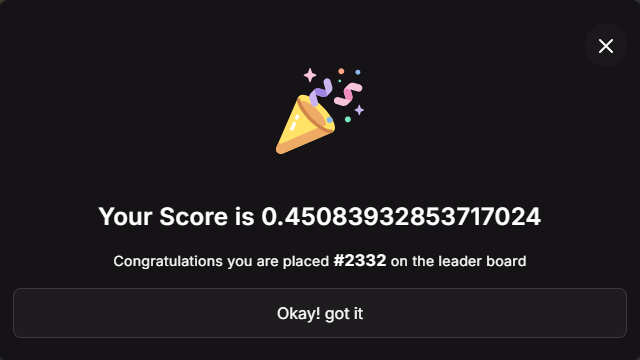

Tried the below GRIDCVSEARCH in Kaggle since it took more time to run in JUpyter notebook in local

# Model Observation